In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from utils.helpers import int2atom, atom2int
import seaborn as sn
from tqdm import tqdm
#import dask.dataframe as dd
#import dask
from dask.diagnostics import ProgressBar

In [3]:
%matplotlib notebook

In [181]:
conn = sqlite3.connect("/work1/s180213/results_zinc.db")
models = conn.execute("select distinct model_id from models where model_name_short not like '%(%'").fetchall()


results_mask = pd.DataFrame()
results_length = pd.DataFrame()

for model in tqdm(models):
    df = pd.read_sql_query(f"""select
                             case
                                 when target=prediction then 1
                                 else 0
                             end as accuracy,
                             case 
                                when target=prediction then 1 
                                when (target=0 
                                        or target=4
                                        or target=7
                                        or target=8
                                        or target=9) 
                                    and (prediction=0 
                                        or prediction=4
                                        or prediction=7
                                        or prediction=8
                                        or prediction=9) then 1
                                when (target=2 or target=6) and (prediction=2 or target=6) then 1
                                when (target=3 or target=5) and (prediction=3 or prediction=5) then 1
                              
                                else 0
                           end as accuracy_octet,

                    case 
                        when (target=0 
                                        or target=4
                                        or target=7
                                        or target=8
                                        or target=9) 
                                    and (prediction=0 
                                        or prediction=4
                                        or prediction=7
                                        or prediction=8
                                        or prediction=9) then target
                                when (target=2 or target=6) and (prediction=2 or target=6) then target
                                when (target=3 or target=5) and (prediction=3 or prediction=5) then target
                        
                        
                        else prediction
                    end as prediction_octet,
                    prediction,
                    target, cross_entropy,num_masks, predictions.model_id, model_name_short, length 
                          from predictions, models, molecules
                          where predictions.model_id=models.model_id 
                          and predictions.molecule_id=molecules.molecule_id
                          and predictions.model_id ='{model[0]}'
                           """, conn)

    f1_mask = df \
                    .groupby(['num_masks','model_id', 'model_name_short']) \
                    .apply(lambda df:pd.Series({
                        'f1 micro':f1_score(df.target, df.prediction, average='micro'),
                        'f1 macro':f1_score(df.target, df.prediction, average='macro'),
                        'f1 micro (octet)':f1_score(df.target, df.prediction_octet, average='micro'),
                        'f1 macro (octet)':f1_score(df.target, df.prediction_octet, average='macro')
                        }
                        )
                     ) \
                    #.groupby(['model_name_short','num_masks']) \
                    #.agg(['mean','std'])

    f1_length = df[df['num_masks']==1]\
                    .groupby(['model_id', 'model_name_short','length']) \
                    .apply(lambda df:pd.Series({
                        'f1 micro':f1_score(df.target, df.prediction, average='micro'),
                        'f1 macro':f1_score(df.target, df.prediction, average='macro'),
                        'f1 micro (octet)':f1_score(df.target, df.prediction_octet, average='micro'),
                        'f1 macro (octet)':f1_score(df.target, df.prediction_octet, average='macro')
                        }
                        )
                     ) \
                    #.groupby(['model_name_short', 'length'])\
                    #.agg(['mean','std'])

    model_df = df.groupby(['num_masks','model_id', 'model_name_short']).mean()
    model_df['pp'] = np.exp(model_df['cross_entropy'])
    #model_df = model_df.groupby(['model_name_short', 'num_masks']).agg(['mean','std'])[['accuracy','accuracy_octet','pp']]
    #model_df

    result_mask = pd.concat([f1_mask, model_df],axis=1)
    results_mask = results_mask.append(result_mask)
    results_length = results_length.append(f1_length)

  0%|          | 0/62 [00:00<?, ?it/s]/zhome/9e/8/130993/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
  3%|▎         | 2/62 [03:53<1:56:05, 116.09s/it]/zhome/9e/8/130993/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
100%|██████████| 62/62 [2:07:15<00:00, 119.41s/it]


In [182]:
results_mask2 = results_mask.groupby(['model_name_short', 'num_masks']).agg(['mean','std'])
results_mask2

In [221]:
asd=results_mask2.reset_index()
asd[asd.num_masks==1][['model_name_short','f1 micro (octet)','f1 macro (octet)', 'f1 micro','f1 macro','pp']]


model_name_short f1 micro (octet)           f1 macro (octet)  \
                                     mean       std             mean   
0           Bag-of-atoms         0.508402  0.002953         0.567463   
9       Bag-of-atoms_old         0.503098  0.008445         0.566493   
18      Bag-of-neighbors         0.907316  0.000305         0.765053   
27  Bag-of-neighbors_old         0.948199  0.000834         0.818922   
36             OctetRule         0.991699       NaN         0.886561   
45               Unigram         0.480531       NaN         0.563964   
54           transformer         0.991309  0.000507         0.913776   
63      transformer bond         0.995243  0.000383         0.979735   

              f1 micro            f1 macro                  pp            
         std      mean       std      mean       std      mean       std  
0   0.005858  0.490622  0.003208  0.098444  0.005279  3.135276  0.007312  
9   0.008407  0.484911  0.009036  0.093326  0.011453  3.157476  0.015644  
18  0.004538  0.889969  0.000302  0.294692  0.003864  1.410521  0.003627  
27  0.002770  0.932984  0.000712  0.432653  0.005123  1.199759  0.002115  
36       NaN  0.972196       NaN  0.383835       NaN  1.164450       NaN  
45       NaN  0.461028       NaN  0.063110       NaN  3.220870       NaN  
54  0.049425  0.981754  0.000605  0.557607  0.048874  1.063226  0.001845  
63  0.031673  0.986398  0.000252  0.626671  0.031915  1.046946  0.000821

<IPython.core.display.Javascript object>


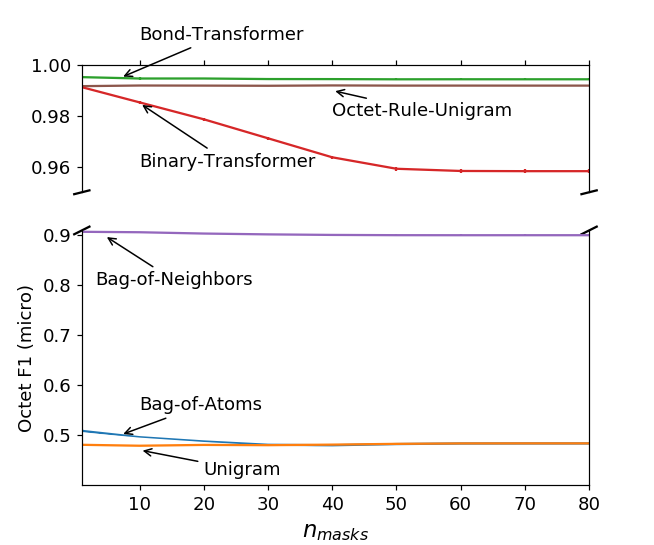

In [195]:
plt.rcParams.update({'font.size': 12})
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet F1 (micro)')

colors = {'Unigram':'C1', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C4',
         'transformer':'C3',
         'transformer bond':'C2',
         'OctetRule':'C5',
         'Bag-of-atoms_old':'W',
         'Bag-of-neighbors_old':'W'}

for key, group in results_mask2['f1 micro (octet)'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.95, 1.00001])
ax2.set_ylim([0.4, 0.91])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.set_yticks([0.5,0.6,0.7,0.8,0.9])
ax.get_legend().remove()
ax2.get_legend().remove()

ax2.annotate('Unigram', xy=(10,0.47), xytext=(20,0.42),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(7,0.5), xytext=(10,0.55),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(4.5,0.9), xytext=(3.1,0.80),arrowprops={'arrowstyle':'->'})
ax.annotate('Binary-Transformer', xy=(10,0.985), xytext=(10,0.96),arrowprops={'arrowstyle':'->'})
ax.annotate('Octet-Rule-Unigram', xy=(40,0.99), xytext=(40,0.98),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.995), xytext=(10,1.01),arrowprops={'arrowstyle':'->'})


ax2.set_xlabel('$n_{masks}$', fontsize=15)
plt.savefig('octet_f1_micro_vs_nmask_zinc.pdf')

<IPython.core.display.Javascript object>


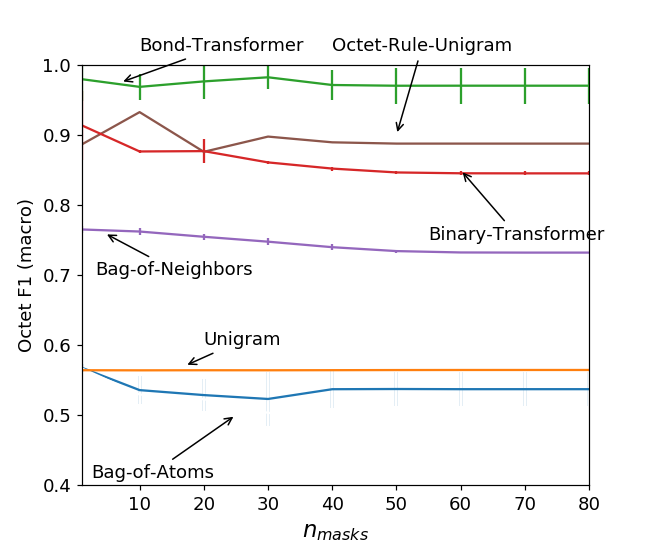

In [202]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
plt.ylabel('Octet F1 (macro)')


for key, group in results_mask2['f1 macro (octet)'].reset_index().groupby('model_name_short'):
    
    #group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
#ax.set_ylim([0.97, 1.00001])
ax.set_ylim([0.4, 1])


#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
#ax.set_xticks([1,5,10,15,20,25,30,90])
#ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1])
#ax.get_legend().remove()
ax.get_legend().remove()
ax.set_xlabel('$n_{masks}$', fontsize=15)

ax.annotate('Unigram', xy=(17,0.57), xytext=(20,0.6),arrowprops={'arrowstyle':'->',})
ax.annotate('Bag-of-Atoms', xy=(25,0.5), xytext=(2.5,0.41),arrowprops={'arrowstyle':'->'})
ax.annotate('Bag-of-Neighbors', xy=(4.5,0.76), xytext=(3.1,0.7),arrowprops={'arrowstyle':'->'})
ax.annotate('Binary-Transformer', xy=(60,0.85), xytext=(55,0.75),arrowprops={'arrowstyle':'->'})
ax.annotate('Octet-Rule-Unigram', xy=(50,0.9), xytext=(40,1.02),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.975), xytext=(10,1.02),arrowprops={'arrowstyle':'->'})


plt.savefig('octet_f1_macro_vs_nmask_zinc.pdf')

<IPython.core.display.Javascript object>


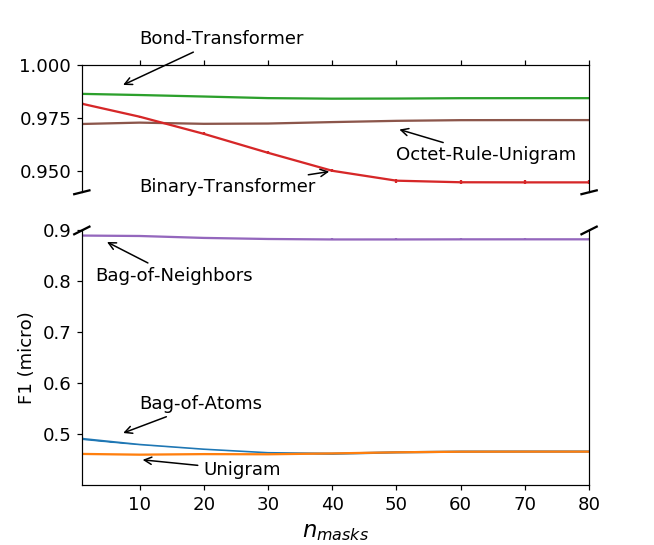

In [207]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('F1 (micro)')


for key, group in results_mask2['f1 micro'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.94, 1.00001])
ax2.set_ylim([0.4, 0.9])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
#ax2.set_xticks([1,5,10,15,20,25,30,91])
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)

ax2.annotate('Unigram', xy=(10,0.45), xytext=(20,0.42),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(7,0.5), xytext=(10,0.55),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(4.5,0.88), xytext=(3.1,0.80),arrowprops={'arrowstyle':'->'})
ax.annotate('Binary-Transformer', xy=(40,0.95), xytext=(10,0.94),arrowprops={'arrowstyle':'->'})
ax.annotate('Octet-Rule-Unigram', xy=(50,0.97), xytext=(50,0.955),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.99), xytext=(10,1.01),arrowprops={'arrowstyle':'->'})

plt.savefig('sample_f1_micro_vs_nmask_zinc.pdf')

<IPython.core.display.Javascript object>


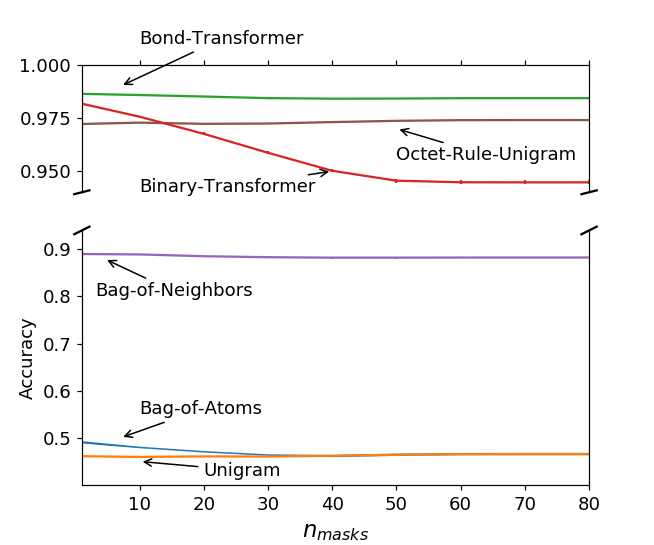

In [210]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Accuracy')


for key, group in results_mask2['accuracy'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.94, 1.00001])
ax2.set_ylim([0.4, 0.94])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
#ax2.set_xticks([1,5,10,15,20,25,30,91])
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9])
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)

ax2.annotate('Unigram', xy=(10,0.45), xytext=(20,0.42),arrowprops={'arrowstyle':'->',})
ax2.annotate('Bag-of-Atoms', xy=(7,0.5), xytext=(10,0.55),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(4.5,0.88), xytext=(3.1,0.80),arrowprops={'arrowstyle':'->'})
ax.annotate('Binary-Transformer', xy=(40,0.95), xytext=(10,0.94),arrowprops={'arrowstyle':'->'})
ax.annotate('Octet-Rule-Unigram', xy=(50,0.97), xytext=(50,0.955),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(7,0.99), xytext=(10,1.01),arrowprops={'arrowstyle':'->'})

plt.savefig('sample_accuracy_vs_nmask_zinc.pdf')

<IPython.core.display.Javascript object>


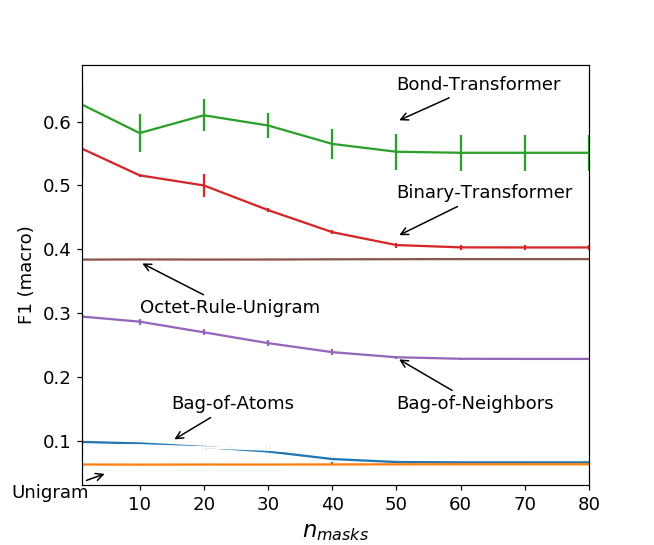

In [214]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
plt.ylabel('F1 (macro)')



for key, group in results_mask2['f1 macro'].reset_index().groupby('model_name_short'):
    
    #group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
#ax.set_ylim([0.97, 1.00001])
#ax.set_ylim([0.4, 1])


#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
#ax.set_xticks([1,5,10,15,20,25,30,90])
#ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1])
#ax.get_legend().remove()
ax.get_legend().remove()
ax.set_xlabel('$n_{masks}$', fontsize=15)

ax.annotate('Unigram', xy=(5,0.05), xytext=(-10,0.01),arrowprops={'arrowstyle':'->',})
ax.annotate('Bag-of-Atoms', xy=(15,0.1), xytext=(15,0.15),arrowprops={'arrowstyle':'->'})
ax.annotate('Bag-of-Neighbors', xy=(50,0.23), xytext=(50,0.15),arrowprops={'arrowstyle':'->'})
ax.annotate('Binary-Transformer', xy=(50,0.42), xytext=(50,0.48),arrowprops={'arrowstyle':'->'})
ax.annotate('Octet-Rule-Unigram', xy=(10,0.38), xytext=(10,0.3),arrowprops={'arrowstyle':'->'})
ax.annotate('Bond-Transformer', xy=(50,0.6), xytext=(50,0.65),arrowprops={'arrowstyle':'->'})


plt.savefig('sample_f1_macro_vs_nmask_zinc.pdf')

<IPython.core.display.Javascript object>


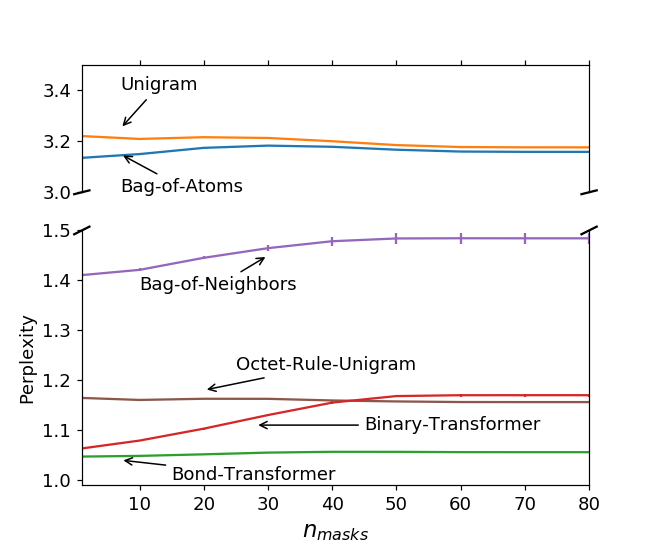

In [216]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Perplexity')


for key, group in results_mask2['pp'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax, color=colors[key])

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2, color=colors[key])

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([3, 3.5])
ax2.set_ylim([0.99,1.5])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)
ax.annotate('Unigram', xy=(7,3.25), xytext=(7,3.4),arrowprops={'arrowstyle':'->',})
ax.annotate('Bag-of-Atoms', xy=(7,3.15), xytext=(7,3.0),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bag-of-Neighbors', xy=(30,1.45), xytext=(10,1.38),arrowprops={'arrowstyle':'->'})
ax2.annotate('Binary-Transformer', xy=(28,1.11), xytext=(45,1.1),arrowprops={'arrowstyle':'->'})
ax2.annotate('Octet-Rule-Unigram', xy=(20,1.18), xytext=(25,1.22),arrowprops={'arrowstyle':'->'})
ax2.annotate('Bond-Transformer', xy=(7,1.04), xytext=(15,1),arrowprops={'arrowstyle':'->'})

plt.savefig('sample_perplexity_vs_nmask_zinc.pdf')

In [261]:
results_length2 = results_length.groupby(['model_name_short', 'length']).agg(['mean','std'])
results_length2

f1 micro            f1 macro            \
                             mean       std      mean       std   
model_name_short length                                           
Bag-of-atoms     13      0.220000  0.063246  0.114167  0.083892   
                 14      0.380000  0.154919  0.120205  0.035492   
                 15      0.380000  0.057349  0.155540  0.038553   
                 16      0.480000  0.103280  0.218667  0.041312   
                 17      0.550000  0.044096  0.179904  0.040197   
                 18      0.267500  0.051438  0.119115  0.032765   
                 19      0.466250  0.048965  0.173473  0.018255   
                 20      0.406364  0.034829  0.133732  0.011711   
                 21      0.362105  0.048922  0.117271  0.019668   
                 22      0.425625  0.017293  0.121670  0.006546   
                 23      0.459259  0.026822  0.127076  0.008363   
                 24      0.476140  0.023915  0.118551  0.006263   
                 25      0.496000  0.021747  0.123933  0.004911   
                 26      0.455306  0.018316  0.127664  0.005468   
                 27      0.440640  0.013768  0.125395  0.003855   
                 28      0.444172  0.012830  0.123345  0.004128   
                 29      0.447980  0.007896  0.110554  0.002032   
                 30      0.440165  0.016207  0.120766  0.005631   
                 31      0.460441  0.007465  0.126800  0.002025   
                 32      0.463130  0.005180  0.126618  0.003575   
                 33      0.448465  0.006730  0.108885  0.002638   
                 34      0.462111  0.003511  0.111959  0.002392   
                 35      0.457191  0.004811  0.123299  0.003575   
                 36      0.469884  0.006020  0.124907  0.005160   
                 37      0.471423  0.004763  0.125849  0.003895   
                 38      0.466788  0.004004  0.123282  0.005166   
                 39      0.470283  0.008139  0.124988  0.005704   
                 40      0.479657  0.005723  0.124408  0.006007   
                 41      0.468284  0.004775  0.107523  0.005385   
                 42      0.489687  0.007133  0.110539  0.006457   
...                           ...       ...       ...       ...   
transformer bond 49      0.989606  0.000520  0.669478  0.004767   
                 50      0.988613  0.000381  0.676401  0.005129   
                 51      0.991514  0.000316  0.660782  0.004302   
                 52      0.991110  0.000464  0.654510  0.002833   
                 53      0.991525  0.000411  0.663967  0.003129   
                 54      0.993148  0.000675  0.786710  0.004795   
                 55      0.992784  0.000271  0.743934  0.004637   
                 56      0.993823  0.000471  0.689126  0.004669   
                 57      0.993074  0.000490  0.767845  0.005852   
                 58      0.994068  0.000808  0.753336  0.010405   
                 59      0.993201  0.000661  0.890613  0.005038   
                 60      0.993304  0.001168  0.692440  0.008436   
                 61      0.992163  0.000803  0.686106  0.006646   
                 62      0.994179  0.000690  0.692649  0.006406   
                 63      0.990705  0.001093  0.656341  0.013139   
                 64      0.995385  0.000758  0.712481  0.001269   
                 65      0.993115  0.002015  0.824876  0.003234   
                 66      0.994286  0.001129  0.827032  0.001798   
                 67      0.994933  0.001968  0.984415  0.005781   
                 68      0.992593  0.003024  0.958017  0.034088   
                 69      0.999524  0.001506  0.998909  0.003452   
                 70      0.975238  0.004918  0.917197  0.012351   
                 71      0.988571  0.006023  0.964306  0.017420   
                 72      0.980000  0.000000  0.745098  0.000000   
                 73      1.000000  0.000000  1.000000  0.000000   
                 74      1.000000  0.000000  1.000000  0.000000   
     

<IPython.core.display.Javascript object>


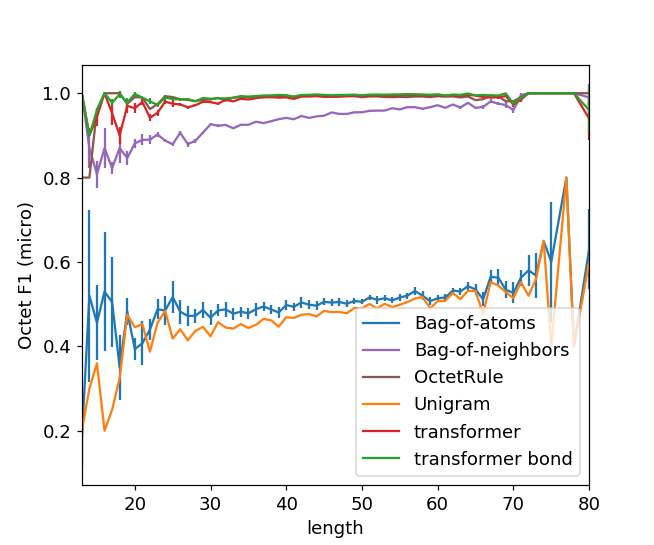

In [217]:
#results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('Octet F1 (micro)')
#ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_length2['f1 micro (octet)'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax, color=colors[key])
    
#ax2.set_xticks(np.arange(5,28, 2.0))
#ax2.set_xlim([4, 28])
#ax2.set_ylim([-0.01,1.03])
#ax2.get_legend().remove()

#ax.hist(df[(df['num_masks']==5)]['length'], density=False, bins=np.arange(5,90)+0.5)
#ax.set_ylabel('Molecule count')
#ax.set_yscale('log')
#ax.set_yticks([1e2,1e4,1e6])
#ax2.set_xlabel('Number of atoms')
plt.savefig('octet_f1_micro_vs_length.pdf')

<IPython.core.display.Javascript object>


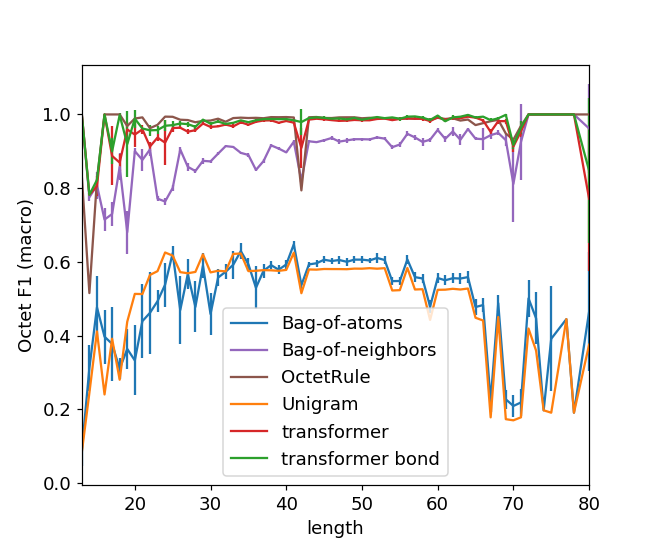

In [218]:
#results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('Octet F1 (macro)')
#ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_length2['f1 macro (octet)'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax, color=colors[key])
    
#ax2.set_xticks(np.arange(5,28, 2.0))
#ax2.set_xlim([4, 28])
#ax2.set_ylim([-0.01,1.03])
#ax2.get_legend().remove()

#ax.hist(df[(df['num_masks']==5)]['length'], density=False, bins=np.arange(5,90)+0.5)
#ax.set_ylabel('Molecule count')
#ax.set_yscale('log')
#ax.set_yticks([1e2,1e4,1e6])
#ax2.set_xlabel('Number of atoms')
#plt.savefig('f1_micro_vs_length_5.pdf')
plt.savefig('octet_f1_macro_vs_length.pdf')

<IPython.core.display.Javascript object>


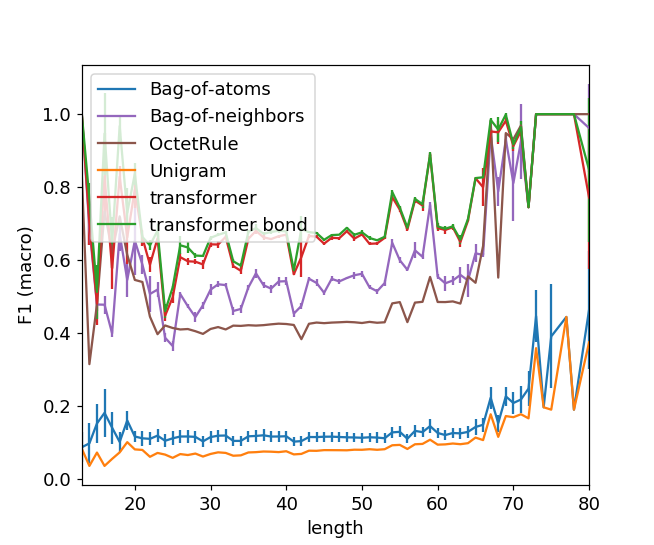

In [219]:
#results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('F1 (macro)')
#ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_length2['f1 macro'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax, color=colors[key])
    
#ax2.set_xticks(np.arange(5,28, 2.0))
#ax2.set_xlim([4, 28])
#ax2.set_ylim([-0.01,1.03])
#ax2.get_legend().remove()

#ax.hist(df[(df['num_masks']==5)]['length'], density=False, bins=np.arange(5,90)+0.5)
#ax.set_ylabel('Molecule count')
#ax.set_yscale('log')
#ax.set_yticks([1e2,1e4,1e6])
#ax2.set_xlabel('Number of atoms')
#plt.savefig('f1_micro_vs_length_5.pdf')
plt.savefig('sample_f1_macro_vs_length.pdf')

<IPython.core.display.Javascript object>


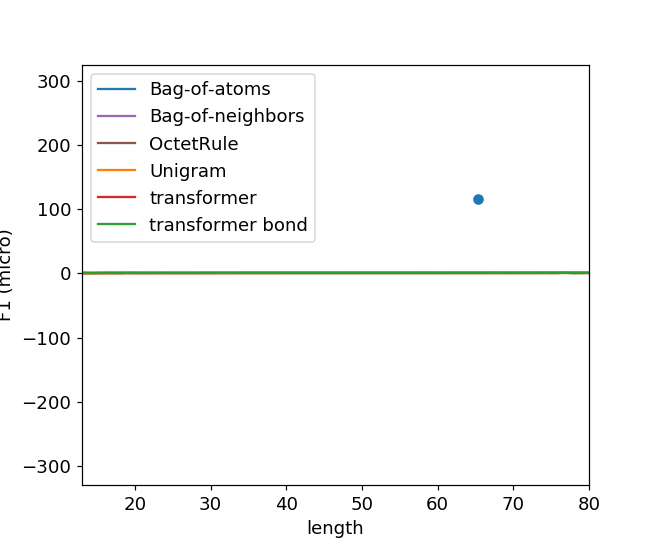

In [220]:
#results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylabel('F1 (micro)')
#ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_length2['f1 micro'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax, color=colors[key])
    
#ax2.set_xticks(np.arange(5,28, 2.0))
#ax2.set_xlim([4, 28])
#ax2.set_ylim([-0.01,1.03])
#ax2.get_legend().remove()

#ax.hist(df[(df['num_masks']==5)]['length'], density=False, bins=np.arange(5,90)+0.5)
#ax.set_ylabel('Molecule count')
#ax.set_yscale('log')
#ax.set_yticks([1e2,1e4,1e6])
#ax2.set_xlabel('Number of atoms')
#plt.savefig('f1_micro_vs_length_5.pdf')
plt.savefig('sample_f1_micro_vs_length.pdf')

<IPython.core.display.Javascript object>


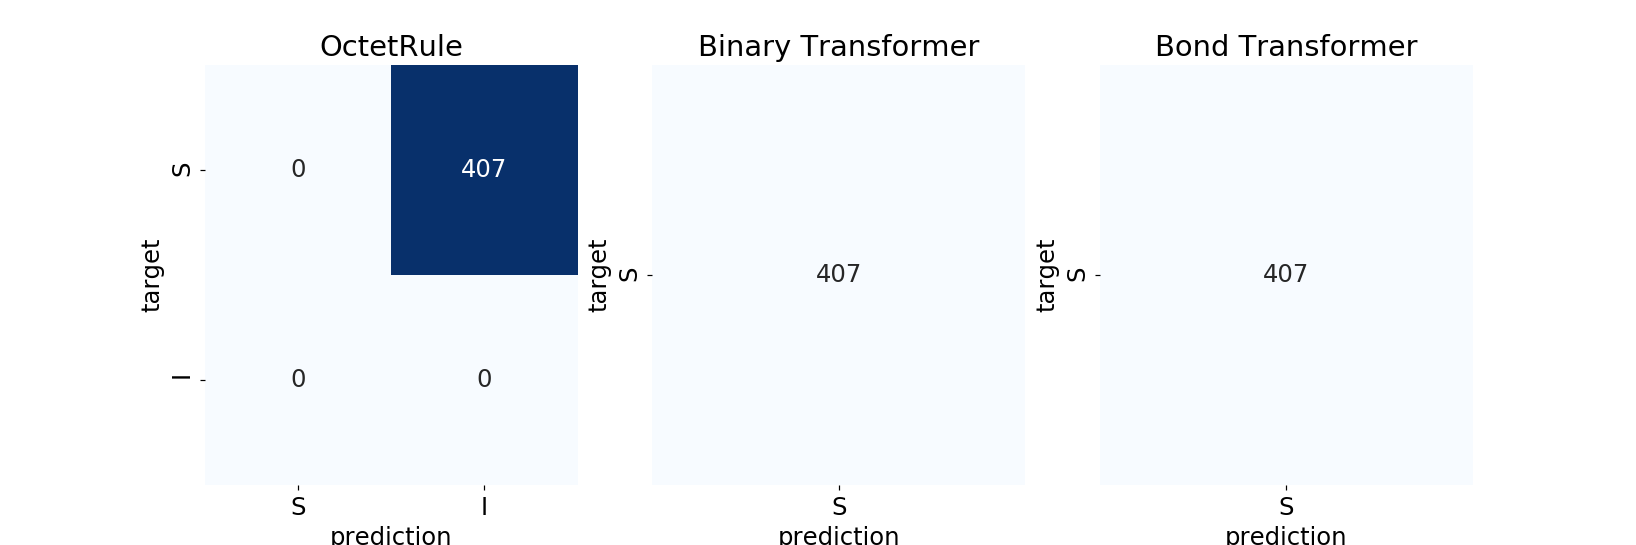

In [179]:
plt.rcParams.update({'font.size': 16})
conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==6]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique())))) 
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])
plt.savefig("confusion_6.pdf")

<IPython.core.display.Javascript object>


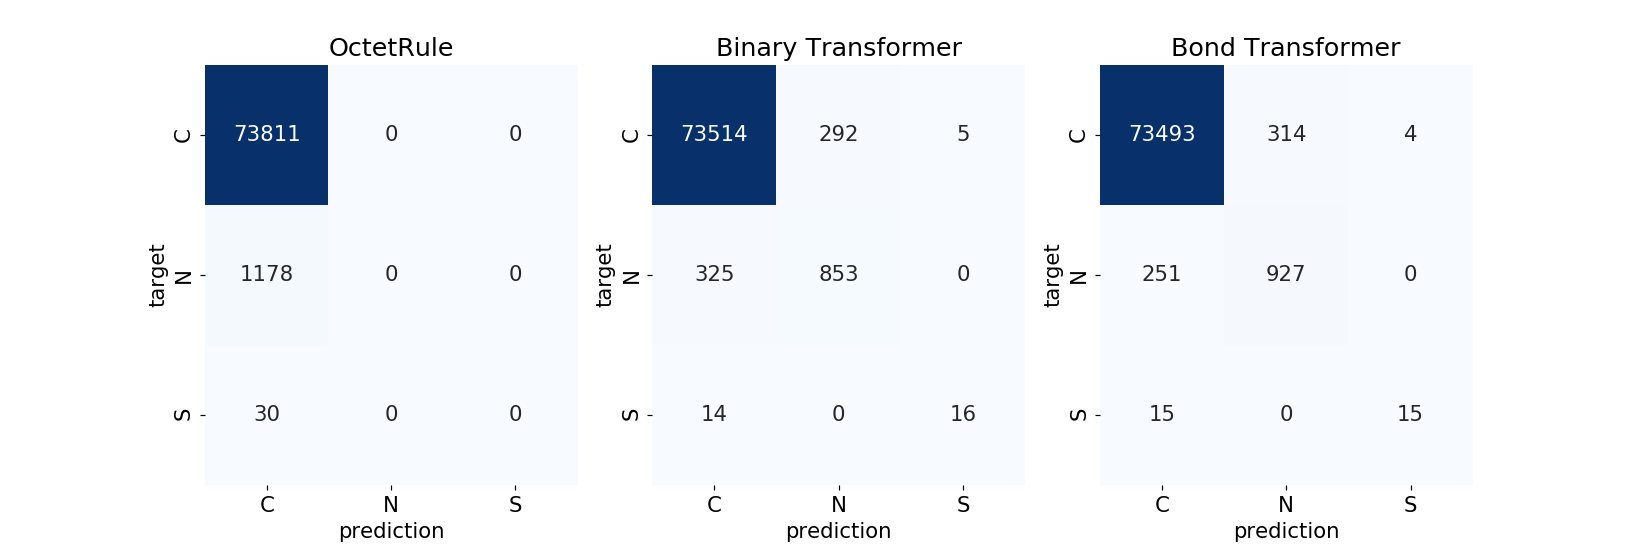

In [177]:
conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==4]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique())))) 
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])
plt.savefig('data/confusion4.pdf')

<IPython.core.display.Javascript object>


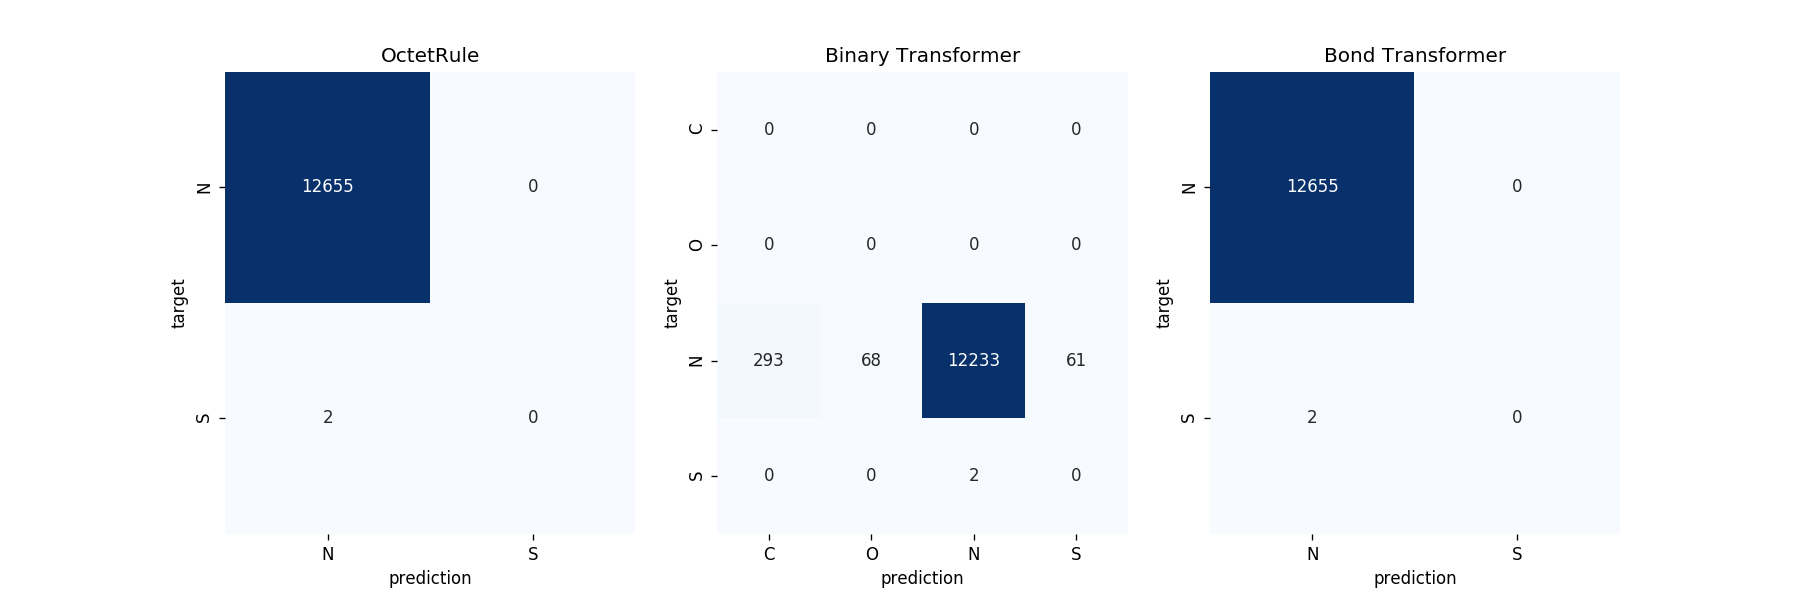

In [30]:
conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==3]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique())))) 
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])
plt.savefig('data/confusion3.pdf')

<IPython.core.display.Javascript object>


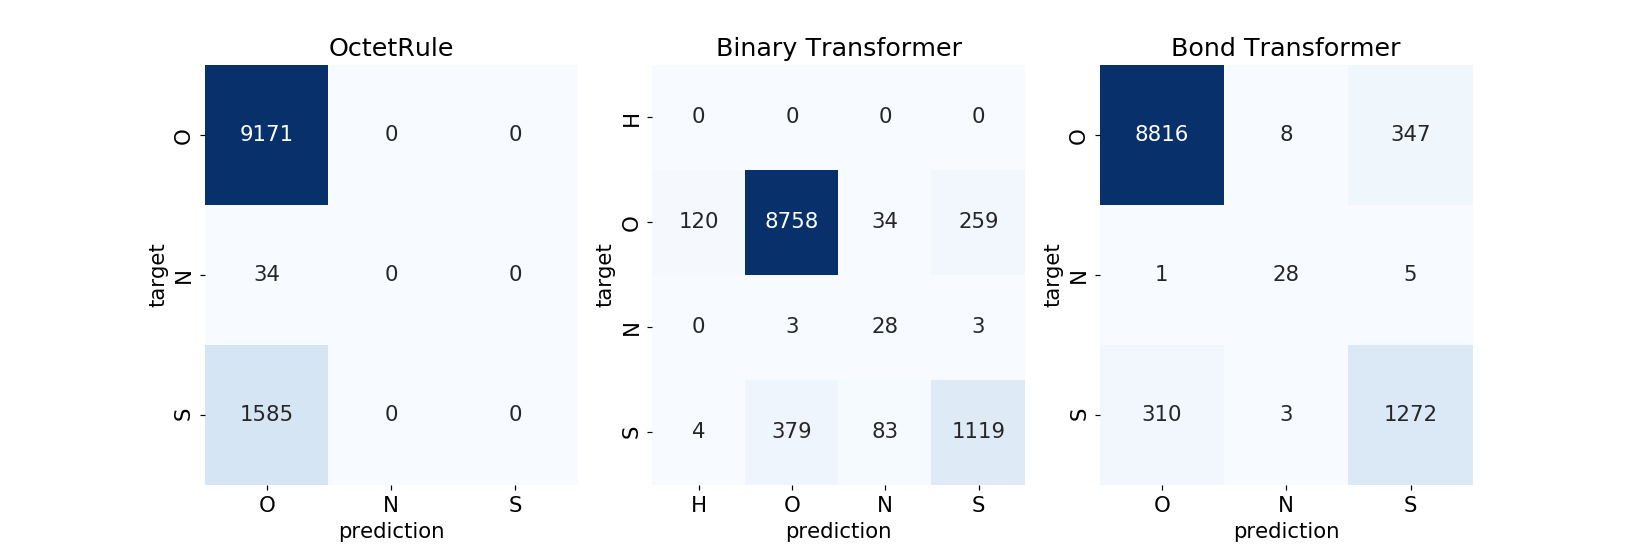

In [176]:

conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==2]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique()))))
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])
plt.savefig('data/confusion2.pdf')

<IPython.core.display.Javascript object>


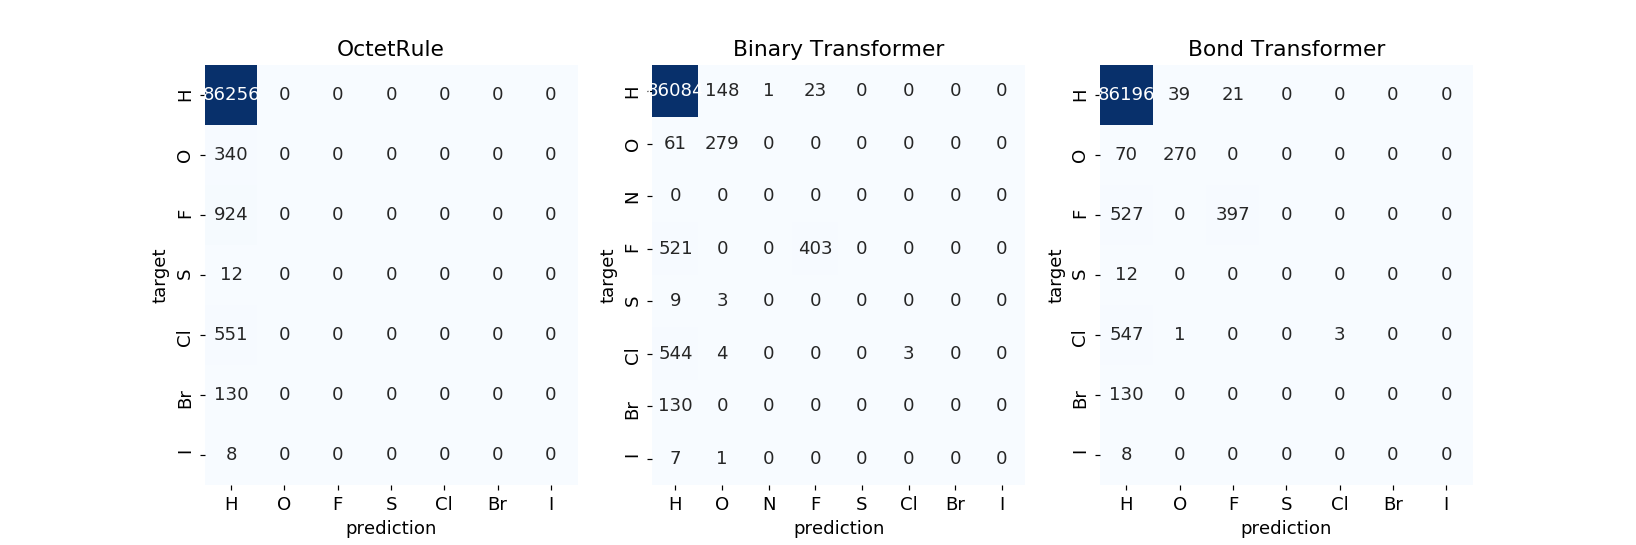

In [255]:
conn = sqlite3.connect("/work1/s180213/results_zinc.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==1]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique()))))
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])
    plt.savefig('data/confusion1.pdf')

<IPython.core.display.Javascript object>


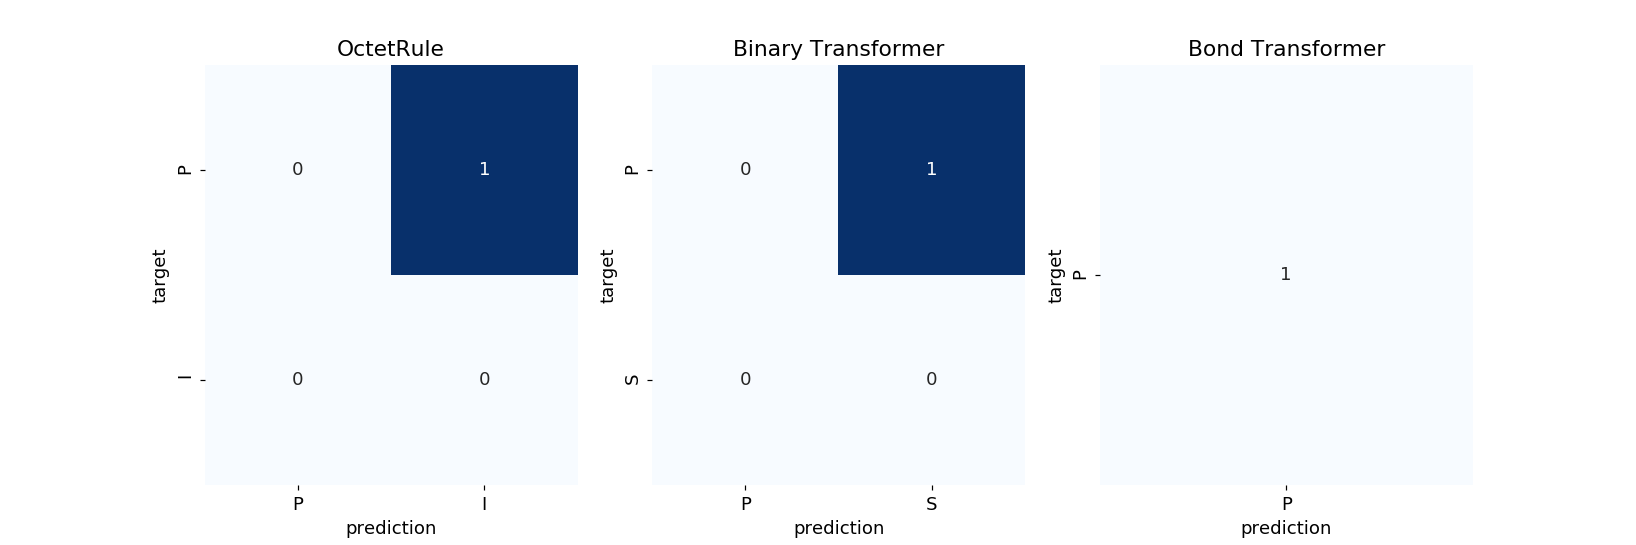

In [265]:
conn = sqlite3.connect("/work1/s180213/results_zinc.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==5]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique()))))
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])
    plt.savefig('data/confusion5.pdf')

In [227]:
from sklearn.manifold import TSNE
import pickle
import torch

<IPython.core.display.Javascript object>


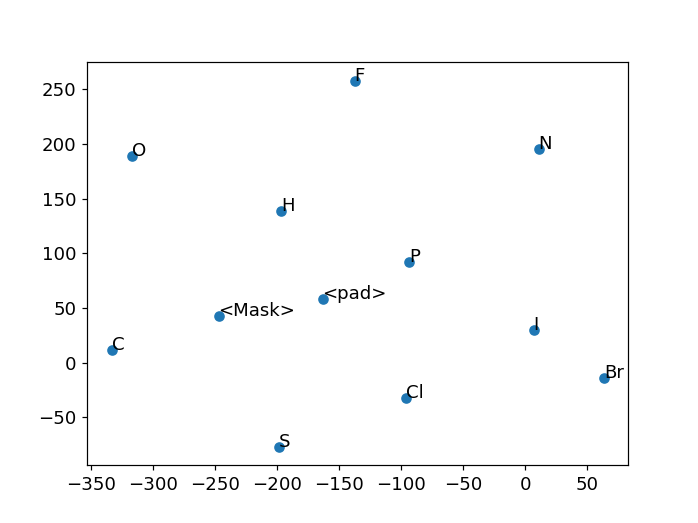

In [263]:
model=torch.load('saved_models/Transformer_num_masks=1_num_fake=0_num_same=0_num_layers=8_num_heads=6_embedding_dim=64_dropout=0.0_lr=0.001_edge_encoding=1_epsilon_greedy=0.2_gamma=1_bond_order=False_dataset=zinc.pt',map_location=torch.device('cpu'))
tsne = TSNE(n_components=2,perplexity=5, n_iter=10000).fit_transform(model['embeddings.weight'])
plt.figure()
labels=['<pad>','H','C','O','N','F','P','S','Cl','Br','I','<Mask>']
colors = ['C1','C2','C3','C4','C5','C2','C4','C3','C2','C2','C2','C6']
plt.scatter(tsne[:,0], tsne[:,1])
for i in range(12):
    plt.annotate(labels[i],(tsne[i,0],tsne[i,1]))
